## Graph of Green Spaces

### The problem


Let's look at an extended example of using libraries to work with Python to analyse data.

We'd like to know how density of green space varies as we move from city centre to the countryside:

* Find the location of two places by name
* Obtain maps or satellite images of the geography at points between them
    * In this toy example: just evenly divide the range
* Determine the proportion of the images that are parkland
    * In this toy example: bits that are green!
* Plot a graph


### Geolocation


Google provides a service to go from "London" to 51.51N, 0.1275W. Fortunately, there's a very nice library
on PyPI to access it: `pip install geopy`




In [11]:
import geopy
geocoder=geopy.geocoders.GoogleV3(domain="maps.google.co.uk")
def geolocate(place):
  return geocoder.geocode(place,exactly_one=False)[0][1]

london_location=geolocate("London")
print london_location

(51.5073509, -0.1277583)


### Addressing the google maps API


Google maps has a static API to obtain satellite images with URLs like this:

[http://maps.googleapis.com/maps/api/staticmap?size=400x400&sensor=false&zoom=10&center=51.5072,-0.1275](http://maps.googleapis.com/maps/api/staticmap?size=400x400&sensor=false&zoom=10&center=51.5072,-0.1275)

We'll therefore need to use a library to build this URL, and fetch the result

`sudo pip install pypng` will get you this library.




In [12]:
import requests
def map_at(lat,long, satellite=False, zoom=12, 
           size=(400,400), sensor=False):
    base="http://maps.googleapis.com/maps/api/staticmap?"
    params=dict(
        sensor= str(sensor).lower(),
        zoom= zoom,
        size= "x".join(map(str,size)),
        center= ",".join(map(str,(lat,long))),
        style="feature:all|element:labels|visibility:off"
    )
    if satellite:
        params["maptype"]="satellite"
    return requests.get(base,params=params)


map_response=map_at(51.5072, -0.1275, zoom=10)
url=map_response.url
print url


http://maps.googleapis.com/maps/api/staticmap?style=feature%3Aall%7Celement%3Alabels%7Cvisibility%3Aoff&center=51.5072%2C-0.1275&sensor=false&zoom=10&size=400x400


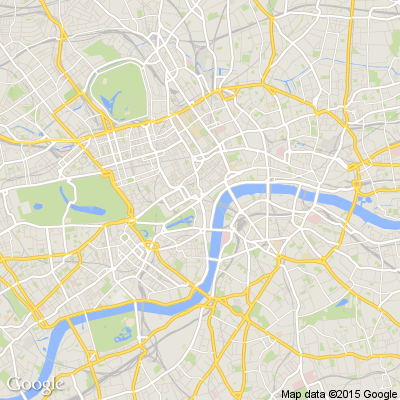

In [13]:
import IPython
map_png=map_at(*london_location)
IPython.core.display.Image(map_png.content)

### Finding the green bits


We'll need a library to parse `.png` image files and determine which bits are green:




In [14]:
def is_green(r,g,b):
  threshold=1.1
  return g>r*threshold and g>b*threshold

import png
from itertools import izip

def count_green_in_png(data):
    image=png.Reader(file=StringIO(data.content)).asRGB()
    count = 0
    for row in image[2]:
        pixels=izip(*[iter(row)]*3)
        count+=sum(1 for pixel in pixels if is_green(*pixel))
    return count

from StringIO import StringIO
print count_green_in_png(map_at(*london_location))

12271


### Checking our code


We could write some unit tests, but for something like this, visualisation is the key to
verification. Let's look which bits are green by building a new png.

We could write the new png to disk, but we can use `StringIO` to get a string in memory which
behaves like a file:




In [15]:
def show_green_in_png(data):
    image=png.Reader(file=StringIO(data.content)).asRGB()
    count = 0
    out=[]
    for row in image[2]:
        outrow=[]
        pixels=izip(*[iter(row)]*3)
        for pixel in pixels:
            outrow.append(0)
            if is_green(*pixel):
                outrow.append(255)
            else:
                outrow.append(0)
            outrow.append(0)
        out.append(outrow)
    buffer=StringIO()
    result = png.from_array(out,mode='RGB')
    result.save(buffer)
    return buffer.getvalue()

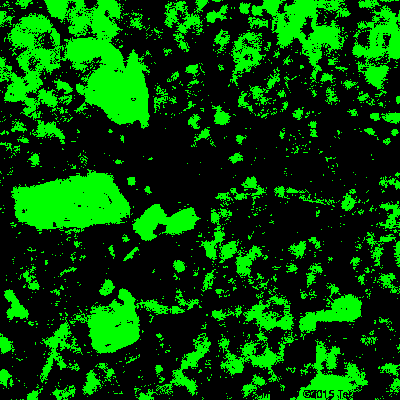

In [16]:
IPython.core.display.Image(show_green_in_png(map_at(*london_location,satellite=True)))

### Points in between


We need all the points equally spaced between two locations.
Numpy has a routine for just this:




In [17]:
from numpy import linspace
def location_sequence(start,end,steps):
  # Would actually prefer this if steps
  # were deduced from zoomlevel
  # But need projection code for that
  lats=linspace(start[0],end[0],steps)
  longs=linspace(start[1],end[1],steps)
  return zip(lats,longs)

[count_green_in_png(map_at(*location,zoom=10,satellite=True))
            for location in location_sequence(
                geolocate("London"),
                geolocate("Birmingham"),
                10)]

[106806,
 127985,
 157091,
 158679,
 158033,
 158833,
 158561,
 156501,
 149482,
 140037]

### The results

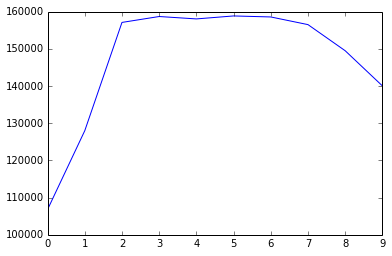

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([count_green_in_png(map_at(*location,zoom=10,satellite=True))
            for location in location_sequence(geolocate("London"),geolocate("Birmingham"),10)])